In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nest_asyncio
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
from cryptography.hazmat.primitives import serialization

# Import the provided client library
from base.clients.clients import KalshiHttpClient, Environment

# Plotting style
sns.set_theme(style="darkgrid")
%matplotlib inline

# --- CONFIGURATION ---
# Load your keys (Assumes you have a kalshi_key.txt or similar, or paste them here)
# NEVER share this notebook with your private keys hardcoded if you publish it.

# Initialize Client
try:
	nest_asyncio.apply()


	load_dotenv()
	env = Environment.PROD
	KEYID = os.getenv('KEYID')
	KEYFILE = os.getenv('KEYFILE')
	try:
		with open(KEYFILE, "rb") as key_file:
			private_key = serialization.load_pem_private_key(
				key_file.read(),
				password=None
			)
	except FileNotFoundError:
		raise FileNotFoundError(f"Private key file not found at {KEYFILE}")
	except Exception as e:
		raise Exception(f"Error loading private key: {str(e)}")

	client = KalshiHttpClient(
		key_id=KEYID,
		private_key=private_key,
		environment=env
	)
	print("✅ Client initialized successfully.")
except Exception as e:
	print(f"❌ Error initializing client: {e}")

✅ Client initialized successfully.


In [2]:
def get_nba_game_markets(limit=500):
	"""
	Fetches recently settled NBA markets and filters for Daily Games.
	"""
	print("Fetching settled NBA markets...")

	# Fetch a large batch to skip past the Season Futures
	response = client.get_markets(
		series_ticker="KXNBAGAME",
		status="settled",
		limit=limit
	)

	if 'markets' not in response:
		print("No markets found.")
		return []

	all_markets = response['markets']

	# --- FILTER LOGIC ---
	# We only want markets with " vs " or " @ " in the title (indicating a match)
	# And exclude "Series" or "Championship" markets

	print(f"Fetched {len(all_markets)} total markets.")
	# print(f"Filtered down to {len(game_markets)} Daily Game markets.")

	return all_markets

# Fetch markets
nba_markets = get_nba_game_markets()

if nba_markets:
	print([x['title'] for x in nba_markets[:5]])
	print(f"\nExample Game Market: {nba_markets[0]['ticker']}")
	print(f"Title: {nba_markets[0]['title']}")

Fetching settled NBA markets...
Fetched 500 total markets.
['Phoenix vs Los Angeles L Winner?', 'Phoenix vs Los Angeles L Winner?', 'Dallas vs Denver Winner?', 'Dallas vs Denver Winner?', 'Houston vs Utah Winner?']

Example Game Market: KXNBAGAME-25DEC01PHXLAL-PHX
Title: Phoenix vs Los Angeles L Winner?


In [3]:
import dateutil.parser

def analyze_market_scalp_potential(market, candle_interval=1):
    ticker = market['ticker']
    series_ticker = "KXNBAGAME"

    # 1. Determine End Time (Close/Expiration)
    end_ts = None
    for key in ['close_ts', 'expiration_ts', 'latest_expiration_ts', 'close_time']:
        if market.get(key):
            val = market[key]
            if isinstance(val, int):
                end_ts = val
                break
            elif isinstance(val, str):
                try:
                    end_ts = int(dateutil.parser.parse(val).timestamp())
                    break
                except:
                    continue

    if end_ts is None:
        return None

    # 2. Define Window: 2 days is enough for a daily game, stop looking 3 hours before game end
    start_ts = end_ts - (60 * 60 * 48)
    end_ts -= (60*60*3)

    try:
        # Fetch candlesticks
        candles_resp = client.get_market_candlesticks(
            series_ticker=series_ticker,
            ticker=ticker,
            start_ts=start_ts,
            end_ts=end_ts,
            period_interval=candle_interval
        )
    except Exception:
        return None

    candles = candles_resp.get('candlesticks', [])
    if not candles:
        return None

    # 3. Strategy Simulation
    first_candle = candles[0]
    yes_ask = first_candle.get('yes_ask')

    if not yes_ask or yes_ask.get('close') is None:
        return None

    open_price = yes_ask['close']

    # Filter: Only trade Favorites (> 50 cents)
    if open_price <= 50:
        return None

    # Exit: Look for highest selling price (Bid) AFTER entry
    max_price = 0
    for candle in candles[1:]:
        yes_bid = candle.get('yes_bid')
        if yes_bid and yes_bid.get('high'):
            if yes_bid['high'] > max_price:
                max_price = yes_bid['high']

    profit_potential = max_price - open_price

    return {
        "ticker": ticker,
        "title": market['title'],
        "open_price": open_price,
        "max_exit_price": max_price,
        "profit_potential": profit_potential,
        "win_5c": profit_potential >= 5,
        "win_10c": profit_potential >= 10,
        "result": market.get('result')
    }

# --- Execute ---
results = []
if nba_markets:
    print(f"Analyzing {len(nba_markets)} game markets...")
    for mkt in nba_markets:
        data = analyze_market_scalp_potential(mkt)
        if data:
            results.append(data)

    df = pd.DataFrame(results)
    print(f"\nAnalysis Complete!")
    print(f"Found {len(df)} tradeable 'Favorite' scenarios.")
    print(df.head())
else:
    print("No markets to analyze.")

Analyzing 500 game markets...

Analysis Complete!
Found 282 tradeable 'Favorite' scenarios.
                        ticker                             title  open_price  \
0  KXNBAGAME-25DEC01PHXLAL-LAL  Phoenix vs Los Angeles L Winner?          69   
1  KXNBAGAME-25DEC01DALDEN-DEN          Dallas vs Denver Winner?          85   
2  KXNBAGAME-25DEC01HOUUTA-HOU           Houston vs Utah Winner?          86   
3  KXNBAGAME-25DEC01CHABKN-CHA     Charlotte vs Brooklyn Winner?          69   
4  KXNBAGAME-25DEC01CHIORL-ORL        Chicago vs Orlando Winner?          78   

   max_exit_price  profit_potential  win_5c  win_10c result  
0              73                 4   False    False     no  
1              85                 0   False    False     no  
2              87                 1   False    False     no  
3              68                -1   False    False     no  
4              78                 0   False    False    yes  


In [4]:
df.head()

,ticker,title,open_price,max_exit_price,profit_potential,win_5c,win_10c,result
0,KXNBAGAME-25DEC01PHXLAL-LAL,Phoenix vs Los Angeles L Winner?,69,73,4,False,False,no
1,KXNBAGAME-25DEC01DALDEN-DEN,Dallas vs Denver Winner?,85,85,0,False,False,no
2,KXNBAGAME-25DEC01HOUUTA-HOU,Houston vs Utah Winner?,86,87,1,False,False,no
3,KXNBAGAME-25DEC01CHABKN-CHA,Charlotte vs Brooklyn Winner?,69,68,-1,False,False,no
4,KXNBAGAME-25DEC01CHIORL-ORL,Chicago vs Orlando Winner?,78,78,0,False,False,yes


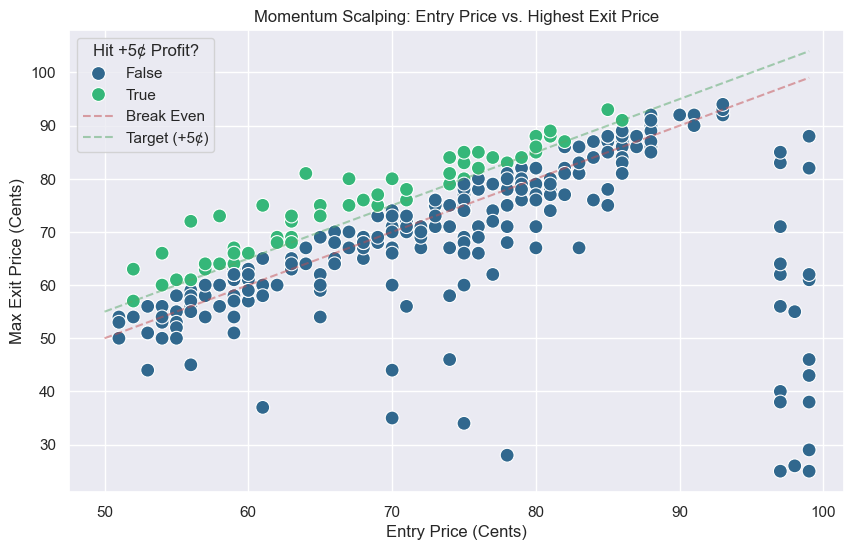

/var/folders/9r/tylbjppj1_92bdn7y4cqgr_w0000gn/T/ipykernel_47683/1580892545.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_rates, x="Target", y="Win Rate", palette="Blues_d")


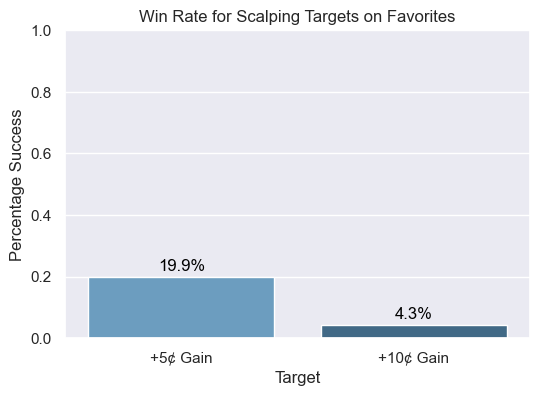

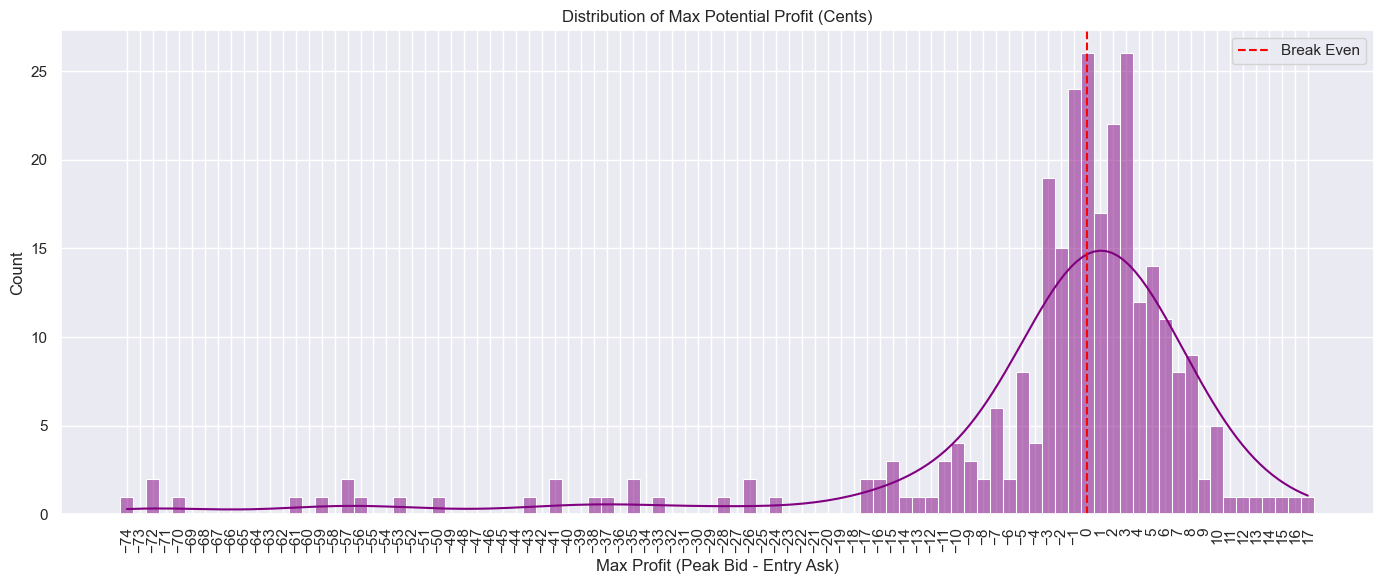

In [5]:
import numpy as np
if not df.empty:
	# 1. Scatter Plot: Entry Price vs Max Exit Price
	plt.figure(figsize=(10, 6))
	sns.scatterplot(data=df, x="open_price", y="max_exit_price", hue="win_5c", palette="viridis", s=100)

	# Add a "Break Even" line
	plt.plot([50, 99], [50, 99], 'r--', label="Break Even", alpha=0.5)
	# Add a "Profit Target" line (+5 cents)
	plt.plot([50, 99], [55, 104], 'g--', label="Target (+5¢)", alpha=0.5)

	plt.title("Momentum Scalping: Entry Price vs. Highest Exit Price")
	plt.xlabel("Entry Price (Cents)")
	plt.ylabel("Max Exit Price (Cents)")
	plt.legend(title="Hit +5¢ Profit?")
	plt.show()

	# 2. Win Rate Bar Chart
	win_rates = pd.DataFrame({
		"Target": ["+5¢ Gain", "+10¢ Gain"],
		"Win Rate": [df['win_5c'].mean(), df['win_10c'].mean()]
	})

	plt.figure(figsize=(6, 4))
	sns.barplot(data=win_rates, x="Target", y="Win Rate", palette="Blues_d")
	plt.ylim(0, 1.0)
	plt.title("Win Rate for Scalping Targets on Favorites")
	plt.ylabel("Percentage Success")
	for index, row in win_rates.iterrows():
		plt.text(index, row['Win Rate'] + 0.02, f"{row['Win Rate']:.1%}", ha='center', color='black')
	plt.show()

	# 3. Distribution of Potential Profit
	plt.figure(figsize=(14, 6)) # Increased width to accommodate more labels

	# Use discrete=True so one bar = one cent, aligning with your labels
	sns.histplot(df['profit_potential'], discrete=True, kde=True, color="purple")

	plt.axvline(0, color='red', linestyle='--', label="Break Even")
	plt.title("Distribution of Max Potential Profit (Cents)")
	plt.xlabel("Max Profit (Peak Bid - Entry Ask)")

	# --- FIX: Set x-axis to show every integer ---
	# Calculate the full range of the data
	min_val = int(df['profit_potential'].min())
	max_val = int(df['profit_potential'].max())

	# Create a tick for every number from min to max
	plt.xticks(np.arange(min_val, max_val + 1, 1), rotation=90)

	plt.legend()
	plt.tight_layout() # Adjust layout to prevent label cutoff
	plt.show()

else:
	print("No data to visualize. Ensure you found markets where the favorite opened > 50c.")

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dateutil.parser

# --- 1. DATA COLLECTION (Fetch Once, Re-use) ---
def fetch_market_candles(markets):
    """Fetches and caches candlestick data to avoid repeated API calls."""
    cache = []
    print(f"Fetching candle data for {len(markets)} markets...")

    for market in markets:
        # A. Get Game Start Time

        end_ts = None
        for key in ['close_ts', 'expiration_ts', 'latest_expiration_ts', 'close_time']:
            if market.get(key):
                val = market[key]
                if isinstance(val, int):
                    end_ts = val
                    break
                elif isinstance(val, str):
                    try:
                        end_ts = int(dateutil.parser.parse(val).timestamp())
                        break
                    except:
                        continue

        if end_ts is None:
            return None

        # B. Define Window (48h Pre-Game)
        start_ts = end_ts - (60 * 60 * 48)
        end_ts -= (60*60*3)

        try:
            resp = client.get_market_candlesticks(
                series_ticker="KXNBAGAME",
                ticker=market['ticker'],
                start_ts=start_ts,
                end_ts=end_ts,
                period_interval=1
            )
            candles = resp.get('candlesticks', [])

            # C. Filter Pre-Game Only

            if candles:
                cache.append({
                    "ticker": market['ticker'],
                    "candles": candles
                })

        except Exception:
            continue

    print(f"Successfully cached data for {len(cache)} markets.")
    return cache

# --- 2. DELAY SIMULATION ---
def test_entry_delays(market_data_cache, delays_minutes):
    stats = []

    for delay in delays_minutes:
        wins = 0
        total_trades = 0

        for data in market_data_cache:
            candles = data['candles']
            if not candles: continue

            # --- APPLY DELAY ---
            # 1. Determine "Start" of data for this market
            data_start_ts = candles[0]['end_period_ts']

            # 2. Calculate Target Entry Time
            target_entry_ts = data_start_ts + (delay * 60)

            # 3. Find the candle closest to (but not before) the target time
            #    This effectively "skips" the first X minutes
            entry_candle = None
            remaining_candles = []

            for i, c in enumerate(candles):
                if c['end_period_ts'] >= target_entry_ts:
                    entry_candle = c
                    remaining_candles = candles[i+1:] # Candles AFTER entry
                    break

            if not entry_candle: continue # Market ended before delay was over

            # --- EXECUTE STRATEGY ---
            yes_ask = entry_candle.get('yes_ask')
            if not yes_ask or not yes_ask.get('close'): continue

            open_price = yes_ask['close']

            # Filter: Favorite Only (> 50 cents)
            if open_price <= 50: continue

            total_trades += 1

            # Check for Profit in REMAINING candles
            max_price = 0
            for c in remaining_candles:
                yes_bid = c.get('yes_bid')
                if yes_bid and yes_bid.get('high'):
                    if yes_bid['high'] > max_price:
                        max_price = yes_bid['high']

            if (max_price - open_price) >= 5:
                wins += 1

        win_rate = (wins / total_trades) if total_trades > 0 else 0
        stats.append({
            "delay_minutes": delay,
            "win_rate": win_rate,
            "trades": total_trades
        })
        print(f"Delay {delay}m: Win Rate {win_rate:.1%} ({wins}/{total_trades} trades)")

    return pd.DataFrame(stats)

Fetching candle data for 500 markets...
Successfully cached data for 500 markets.
Delay 0m: Win Rate 19.9% (56/282 trades)
Delay 15m: Win Rate 20.1% (57/284 trades)
Delay 30m: Win Rate 18.8% (54/288 trades)
Delay 60m: Win Rate 18.0% (51/284 trades)
Delay 120m: Win Rate 17.3% (48/278 trades)
Delay 240m: Win Rate 16.3% (45/276 trades)


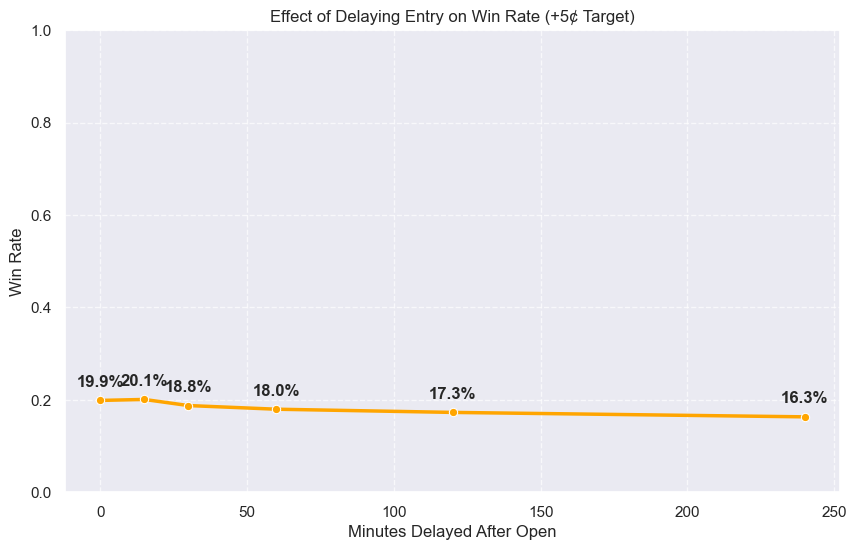

In [7]:

# --- EXECUTE ---
if 'nba_markets' in locals() and nba_markets:
    # 1. Fetch Data
    cached_data = fetch_market_candles(nba_markets)

    if cached_data:
        # 2. Test Hypotheses: 0m vs 15m vs 30m vs 60m vs 120m delays
        delays = [0, 15, 30, 60, 120, 240]
        results_df = test_entry_delays(cached_data, delays)

        # 3. VISUALIZE
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results_df, x='delay_minutes', y='win_rate', marker='o', linewidth=2.5, color='orange')

        # Style
        plt.title("Effect of Delaying Entry on Win Rate (+5¢ Target)")
        plt.xlabel("Minutes Delayed After Open")
        plt.ylabel("Win Rate")
        plt.ylim(0, 1.0)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Annotate points
        for index, row in results_df.iterrows():
            plt.text(row['delay_minutes'], row['win_rate'] + 0.03,
                     f"{row['win_rate']:.1%}", ha='center', fontweight='bold')

        plt.show()
    else:
        print("No valid candle data found to test.")
else:
    print("No markets found. Run previous cells to get 'nba_markets'.")


Standard Deviation (Volatility) by Interval:
Interval
0m to 15m      6.184129
15m to 30m     2.111156
30m to 60m     5.635161
60m to 120m    5.891393
Name: Price Change (Cents), dtype: float64


/var/folders/9r/tylbjppj1_92bdn7y4cqgr_w0000gn/T/ipykernel_47683/761089482.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


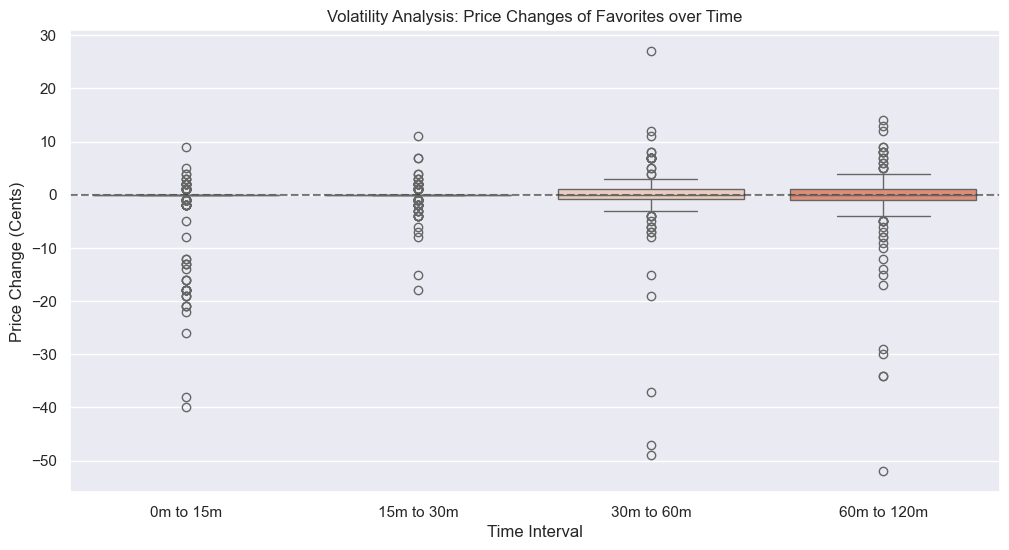

In [8]:
def analyze_price_deltas(market_data_cache, time_points=[0, 15, 30, 60, 120]):
    price_changes = []

    for data in market_data_cache:
        candles = data['candles']
        if not candles: continue

        # Get start time
        data_start_ts = candles[0]['end_period_ts']

        # Collect prices at each time point
        prices = {}
        valid_market = True

        for minutes in time_points:
            target_ts = data_start_ts + (minutes * 60)

            # Find closest candle at or after target time
            found_price = None
            for c in candles:
                if c['end_period_ts'] >= target_ts:
                    # Use 'yes_ask' close as a proxy for buy price
                    if c.get('yes_ask') and c['yes_ask'].get('close'):
                        found_price = c['yes_ask']['close']
                    break

            if found_price is None:
                valid_market = False
                break

            prices[minutes] = found_price

        # Only process if we have prices for all requested time points
        if valid_market:
            # Check if it started as a favorite (Condition from strategy)
            if prices[0] > 50:
                # Calculate differences between consecutive intervals
                for i in range(len(time_points) - 1):
                    t_curr = time_points[i]
                    t_next = time_points[i+1]

                    delta = prices[t_next] - prices[t_curr]

                    price_changes.append({
                        "Interval": f"{t_curr}m to {t_next}m",
                        "Price Change (Cents)": delta,
                        "sort_key": i # Helper for sorting chart
                    })

    return pd.DataFrame(price_changes)

# --- EXECUTE & VISUALIZE ---
if 'cached_data' in locals() and cached_data:
    # 1. Calculate Deltas
    # We look at 0-15m, 15-30m, 30-60m, etc.
    deltas_df = analyze_price_deltas(cached_data, time_points=[0, 15, 30, 60, 120])

    if not deltas_df.empty:
        # 2. Plot
        plt.figure(figsize=(12, 6))

        # Boxplot shows the median and interquartile range (volatility)
        sns.boxplot(
            data=deltas_df,
            x="Interval",
            y="Price Change (Cents)",
            palette="coolwarm"
        )

        # Add a reference line at 0 (No change)
        plt.axhline(0, color='black', linestyle='--', alpha=0.5)

        plt.title("Volatility Analysis: Price Changes of Favorites over Time")
        plt.ylabel("Price Change (Cents)")
        plt.xlabel("Time Interval")

        # Calculate Standard Deviation to quantify "Instability"
        std_devs = deltas_df.groupby("Interval")['Price Change (Cents)'].std()
        print("\nStandard Deviation (Volatility) by Interval:")
        print(std_devs)

        plt.show()
    else:
        print("No valid data points found (check if markets had favorites > 50c).")
else:
    print("Please run the 'Fetch Candles' cell first to populate 'cached_data'.")

In [ ]:
import pandas as pd
import dateutil.parser

def analyze_scalp_ev(market, candle_interval=1):
	ticker = market['ticker']
	series_ticker = "KXNBAGAME"

	# 1. Determine End Time (Close/Expiration)
	end_ts = None
	for key in ['close_ts', 'expiration_ts', 'latest_expiration_ts', 'close_time']:
		if market.get(key):
			val = market[key]
			if isinstance(val, int):
				end_ts = val
				break
			elif isinstance(val, str):
				try:
					end_ts = int(dateutil.parser.parse(val).timestamp())
					break
				except:
					continue

	if end_ts is None:
		print("none")
		return None

	# 2. Define Window: 2 days is enough for a daily game, stop looking 3 hours before game end
	start_ts = end_ts - (60 * 60 * 48)
	end_ts -= (60*60*3)

	print(start_ts, end_ts)

	try:
		resp = client.get_market_candlesticks(
			series_ticker=series_ticker,
			ticker=ticker,
			start_ts=start_ts,
			end_ts=end_ts,
			period_interval=candle_interval
		)
		candles = resp.get('candlesticks', [])
	except:
		print("none 2")
		return None

	if not candles:
		print("none 3")
		return None

	# Filter strictly pre-game
	pre_game_candles = [c for c in candles if c['end_period_ts'] <= start_ts]
	if not pre_game_candles:
		print("none 4")
		return None

	# --- STRATEGY DATA POINTS ---

	# Entry: Open Price
	first_candle = pre_game_candles[0]
	yes_ask = first_candle.get('yes_ask')
	if not yes_ask or not yes_ask.get('close'):
		print("none 5")
		return None
	open_price = yes_ask['close']

	# Filter: Favorites Only
	if open_price <= 50:
		print("None 7")
		return None

	# High: Max potential exit
	max_price = 0
	for c in pre_game_candles[1:]:
		if c.get('yes_bid') and c['yes_bid'].get('high'):
			max_price = max(max_price, c['yes_bid']['high'])

	# Exit (Fail Case): Last price before game starts
	last_candle = pre_game_candles[-1]
	last_price = 0
	if last_candle.get('yes_bid') and last_candle['yes_bid'].get('close'):
		last_price = last_candle['yes_bid']['close']
	elif last_candle.get('mid_price'): # Fallback
		 last_price = last_candle['mid_price']

	return {
		"ticker": ticker,
		"open_price": open_price,
		"max_price": max_price,
		"last_pre_game_price": last_price,
		"max_profit": max_price - open_price,
		"forced_exit_pl": last_price - open_price # P/L if we hold until game start
	}

# --- FETCH DATA ---
ev_results = []
if 'nba_markets' in locals() and nba_markets:
	print(f"Analyzing {len(nba_markets)} markets for Expected Value...")
	for m in nba_markets:
		res = analyze_scalp_ev(m)
		if res: ev_results.append(res)

	df_ev = pd.DataFrame(ev_results)
	print(f"Data collected for {len(df_ev)} trades.")
else:
	print("No markets found. Run previous cells first.")

Analyzing 500 markets for Expected Value...
1764481177 1764643177
none 4
1764481177 1764643177
none 4
1764477271 1764639271
none 4
1764477271 1764639271
none 4
1764479374 1764641374
none 4
1764479374 1764641374
none 4
1764472489 1764634489
none 4
1764472489 1764634489
none 4
1764473975 1764635975
none 4
1764473975 1764635975
none 4
1764472488 1764634488
none 4
1764472488 1764634488
none 4
1764470990 1764632990
none 4
1764470990 1764632990
none 2
1764470989 1764632989
none 4
1764470989 1764632989
none 4
1764470095 1764632095
none 4
1764470095 1764632095
none 4
1764392068 1764554068
none 2
1764392068 1764554068
none 2
1764392975 1764554975
none 2
1764392975 1764554975
none 2
1764384277 1764546277
none 2
1764384277 1764546277
none 2
1764383071 1764545071
none 2
1764383071 1764545071
none 2
1764380383 1764542383
none 2
1764380383 1764542383
none 2
1764380383 1764542383
none 2
1764380383 1764542383
none 2
1764380080 1764542080
none 2
1764380080 1764542080
none 2
1764370190 1764532190
none 4